In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook



import os as os

import matplotlib.pyplot as plt

def imshow(img, cmap=None):
    plt.close('all')
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.show()
    
import scipy.ndimage as ndimage
from scipy import misc
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sig
from scipy.integrate import simpson
from IPython.display import SVG, display, IFrame, HTML
%matplotlib notebook

C:\Users\meyjoh\repos\vlcompimg\compimg\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def createPillobxResponse(r, x_size, y_size):
    X,Y = np.meshgrid(np.arange(-1*np.floor(x_size/2),np.floor(x_size/2)+1,1), np.arange(-1*np.floor(y_size/2),np.floor(y_size/2)+1,1))
    psf = np.zeros_like(X)
    psf[np.sqrt(X**2+Y**2) <= r] = 1
    return psf, X, Y
def fourier_conv(img:np.ndarray, kernel:np.ndarray) -> np.ndarray:
    
    img_fft = np.fft.fft2(img)
    
    kernel_padded = pad_like(kernel, img)
    kernel_padded_fft = np.fft.fft2(np.fft.ifftshift(kernel_padded))
    
    result = np.real(np.fft.ifft2(img_fft * kernel_padded_fft))
    
        
    return result

def fourier_conv_pre(img:np.ndarray, kernel_padded_fft:np.ndarray) -> np.ndarray:
    
    img_fft = np.fft.fft2(img)
    
        
    result = np.real(np.fft.ifft2(img_fft * kernel_padded_fft))
    
        
    return result

def mag_square(inp : np.ndarray):
    return inp.real**2 + inp.imag**2
def pad_like(inp : np.ndarray, like : np.ndarray):
    to_pad = tuple(np.int32((np.array(like.shape) - np.array(inp.shape))/2))
    return np.pad(inp, ((to_pad[0], to_pad[0]), (to_pad[1], to_pad[1])))
def make_odd_shapes(inp : np.ndarray) -> np.ndarray:
    if (inp.shape[0] % 2 == 0):
        inp = inp[0:-1,:]
    if (inp.shape[1] % 2 == 0):
        inp = inp[:,0:-1]
    return inp

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Diffuser-Cam" data-toc-modified-id="Diffuser-Cam-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Diffuser Cam</a></span><ul class="toc-item"><li><span><a href="#Gradient-based-reconstruction" data-toc-modified-id="Gradient-based-reconstruction-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Gradient-based reconstruction</a></span></li><li><span><a href="#Alternating-direction-method-of-multipliers" data-toc-modified-id="Alternating-direction-method-of-multipliers-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Alternating direction method of multipliers</a></span></li></ul></li></ul></div>

$\begin{align}
  \newcommand{transp}{^\intercal}
  \newcommand{F}{\mathcal{F}}
  \newcommand{Fi}{\mathcal{F}^{-1}}
  \newcommand{inv}{^{-1}}
  \newcommand{stochvec}[1]{\mathbf{\tilde{#1}}}
  \newcommand{argmax}[1]{\underset{#1}{\mathrm{arg\, max}}\,}
  \newcommand{argmin}[1]{\underset{#1}{\mathrm{arg\, min}}\,}
\end{align}$
# Diffuser Cam

In this exercise we will try to implement the reconstruction algorithms for the lensless Diffuser Cam.

Try to derive necessary mathematical formulations by your own. If get stuck (and maybe also frustrated), you can have a look at the excellent tutorial here: https://github.com/Waller-Lab/DiffuserCam-Tutorial

Test your code with the provided example PSF `psf_sample.tif` and the example raw data `rawdata_hand_sample.tif`.

## Gradient-based reconstruction

Implement gradient descent for the reconstruction (without regularizers).

For the first approach, we will not use any prior and just try to find an estimate $\hat{\mathbf{v}}$ that optimizes the data fidelity term:

$\begin{align} 
   \hat{\mathbf{v}} &= \argmin{\mathbf{v}} \frac{1}{2} \left\| \underbrace{\mathbf{CH}}_{=:\mathbf{A}}\mathbf{v} - \mathbf{b} \right\|^2_2  \\
   &= \argmin{\mathbf{v}} \underbrace{\frac{1}{2} \left\| \mathbf{A}\mathbf{v} - \mathbf{b} \right\|^2_2}_{=:g(\mathbf{v})} \,,
\end{align}$

with $\mathbf{H}$ representing a matrix encoding a cyclic convolution with the PSF $h$, $\mathbf{C}$ denoting a matrix encoding the crop operator $\mathcal{C}$ and $\mathbf{A} := \mathbf{CH}$.

According to the lecture notes, the sought gradient is given by

$\begin{align} 
   \nabla_\mathbf{v} g(\mathbf{v}) = \nabla_\mathbf{v} \frac{1}{2} \left\| \mathbf{A}\mathbf{v} - \mathbf{b} \right\|^2_2 = \mathbf{A}\transp (\mathbf{Av}-\mathbf{b}) = \mathbf{H}\transp \mathbf{C}\transp \left( \mathbf{CHv} - \mathbf{b}  \right) \,.
\end{align}$

The transpose $\mathbf{C}\transp$ of the crop operation corresponds to zero padding.

We can now implement the gradient descent iteration:

In [3]:
psf = np.float32(plt.imread("psf_sample.tif"))
psf = make_odd_shapes(psf)
psf[0,0] = 0
psf[0,1] = 0
bg = np.mean(psf[5:15,5:15]) 
psf = psf - bg
psf[psf < 0] = 0
psf = psf / np.linalg.norm(psf.ravel())

In [4]:
img = np.float32(plt.imread("rawdata_hand_sample.tif"))
img[0,0] = 0
img[0,1] = 0
img = make_odd_shapes(img)
img = img - bg
img[img < 0] = 0
img = img / np.linalg.norm(img.ravel())

In [5]:
img.shape, psf.shape

((1199, 1599), (1199, 1599))

In [6]:
target_shape = (int(img.shape[0] * 1.5), int(img.shape[1] * 1.5))

In [7]:
target_img = make_odd_shapes(np.zeros(target_shape))

In [8]:
kernel_padded = pad_like(psf, target_img)
psf_fft = np.fft.fft2(np.fft.ifftshift(kernel_padded))
psf_fft_c = np.conjugate(psf_fft)

In [9]:
alpha = np.real(1.8/(np.max(psf_fft_c * psf_fft)))

In [10]:
def crop_like(inp:np.ndarray, like:np.ndarray)->np.ndarray:
    to_crop = tuple(np.int32((np.array(inp.shape) - np.array(like.shape))/2))
    return inp[to_crop[0]:-to_crop[0], to_crop[1]:-to_crop[1]]

In [ ]:
v = np.zeros_like(target_img)
num_iter = 100

for i in range(0,num_iter):
    print(i/num_iter)
    v = v - alpha*fourier_conv_pre(pad_like(crop_like(fourier_conv_pre(v, psf_fft), img) - img, target_img), psf_fft_c)
    v[v < 0] = 0
v_grad = v

In [ ]:
np.savez_compressed("ex6_grad_res", v_grad)

In [11]:
v_grad = np.load("ex6_grad_res.npz")['arr_0']

<IPython.core.display.Javascript object>


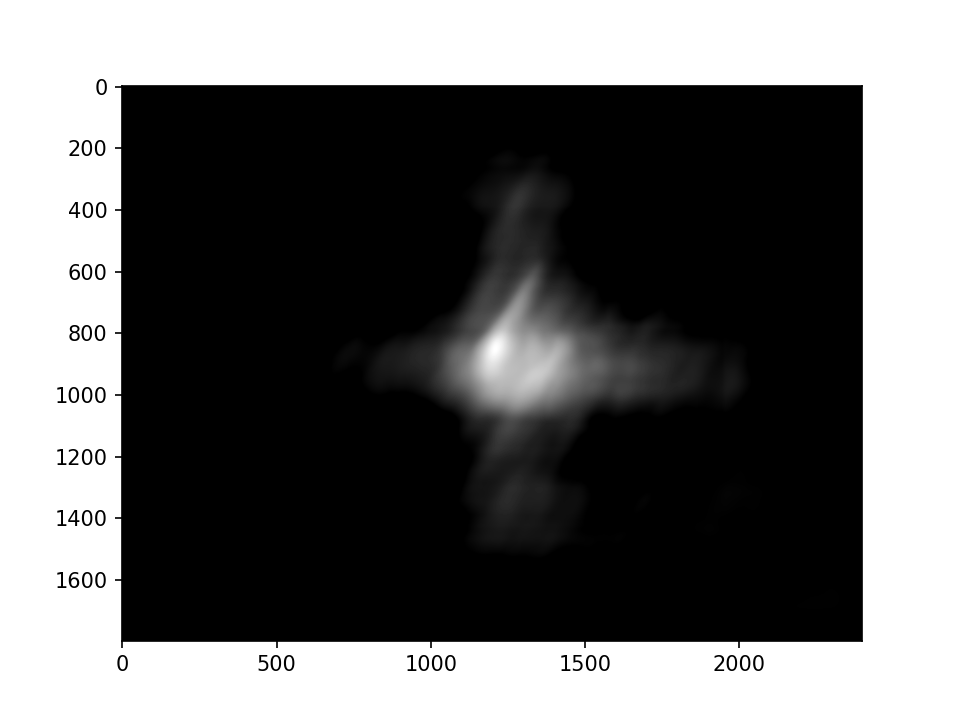

In [12]:
imshow(v_grad, cmap='gray')

## Alternating direction method of multipliers

Implement the reconstruction using the ADMM framework and also include regularization.

We want to solve the following optimization problem:

$\begin{align} 
  \hat{\mathbf{v}} = &\argmin{\mathbf{q}, \mathbf{w}, \mathbf{u}} \frac{1}{2} \left\| \mathbf{C} \mathbf{q} - \mathbf{b} \right\| ^2_2 + \mathrm{pos}(\mathbf{w}) + \tau \left\| \mathbf{u} \right\|_1  \\ &\text{subject to}\quad \mathbf{q} = \mathbf{Hv},\, \mathbf{w}=\mathbf{v},\, \mathbf{u} = \Psi \mathbf{v} \,.   
\end{align}$

In contrast to the lecture, we take the augmented Lagrangian in scaled form:

$\begin{align} 
   L(\mathbf{\mathbf{u,q,w,v,\tilde{u},\tilde{q},\tilde{w}}}) = &\frac{1}{2} \left\| \mathbf{C} \mathbf{q} - \mathbf{b} \right\| ^2_2 + \mathrm{pos}(\mathbf{w}) + \tau \left\| \mathbf{u} \right\|_1 \\
    & + \frac{\mu_1}{2} \left\| \mathbf{Hv} - \mathbf{q} + \mathbf{\tilde{q}} \right\|^2_2 + \left\| \mathbf{\tilde{q}} \right\|^2_2   \\
    & + \frac{\mu_2}{2}\left\| \Psi \mathbf{v-u} + \mathbf{\tilde{u}} \right\|^2_2 + \left\| \mathbf{\tilde{u}} \right\|^2_2  \\
    & + \frac{\mu_3}{2} \left\| \mathbf{v-w+\tilde{w}} \right\| ^2_2 + \left\| \mathbf{\tilde{w}} \right\|^2_2  \,,
\end{align}$

with $\tilde{\mathbf{q}}, \tilde{\mathbf{u}}, \tilde{\mathbf{w}}$ denoting the scaled Lagrange multipliers associated with $\mathbf{q,u,w}$ and $\mu_1, \mu_2, \mu_3$ denoting the corresponding weights.

We now have to derive the update rules for $\mathbf{q,u,w,v}, \tilde{\mathbf{q}}, \tilde{\mathbf{u}}, \tilde{\mathbf{w}}$.

##### $\mathbf{q}$-update

We have to minimize 

$\begin{align} 
   \frac{1}{2} \left\| \mathbf{Cq} - \mathbf{b} \right\| ^2_2 + \frac{\mu_1}{2} \left\|\mathbf{Hv-q} + \mathbf{\tilde{q}} \right\| ^2_2
\end{align}$

with respect to $\mathbf{q}$.

Calculating the gradient of that expression w.r.t. $\mathbf{q}$ yields:

$\begin{align} 
   \mathbf{C}\transp (\mathbf{Cq-b}) + \mu_1 \left( -\mathbf{Hv} + \mathbf{q} - \mathbf{\tilde{q}} \right) \,,
\end{align}$

and equating to zero yields the sought update rule:

$\begin{align} 
   \mathbf{q} \leftarrow \left( \mathbf{C}\transp \mathbf{C} + \mu_1 \mathbf{I} \right) ^{-1} \left( \mathbf{C}\transp \mathbf{b} + \mu_1 \mathbf{Hv} + \mu_1 \mathbf{\tilde{q}} \right) \,.
\end{align}$

In [13]:
def q_upd(mu_1, b, v, H_fft, qt):
    res = 1/mu_1 * (pad_like(b, qt) + mu_1 * fourier_conv_pre(v, H_fft) + mu_1 * qt)
    return res

In [14]:
def q_upd(mu_1, b, v, H_fft, qt):
    res = 1/(mu_1 + 1) * (pad_like(b, qt) + mu_1 * fourier_conv_pre(v, H_fft) + mu_1 * qt)
    return res

##### $\mathbf{u}$-update

We have to minimize

$\begin{align} 
   \tau \left\| \mathbf{u} \right\| _1 + \frac{\mu _2}{2} \left\| \Psi \mathbf{v-u} + \mathbf{\tilde{u}} \right\| ^2_2
\end{align}$

with respect to $\mathbf{u}$.

According to the lecture notes from Chapter 6, the sought expression is exactly the soft-thresholding operator:

$\begin{align} 
   \mathbf{u} \leftarrow \mathcal{S}_{\tau / \mu_2}(\Psi \mathbf{v} + \mathbf{\tilde{u}})\,.
\end{align}$

In [15]:
def u_upd_min_1_norm(x, lam, rho):
    u = np.zeros_like(x)
    u_case1 = x + lam/rho
    u_case3 = x - lam/rho
    
    u[x < -lam/rho] = u_case1[x < -lam/rho]
    u[np.abs(x) <= lam/rho] = 0
    u[x > lam/rho] = u_case3[x > lam/rho]
    
    return u
    

##### $\mathbf{w}$-update

We have to minimize

$\begin{align} 
   \mathrm{pos}(\mathbf{w}) + \frac{\mu _3 }{2} \left\| \mathbf{v-w} + \mathbf{\tilde{w}} \right\| ^2_2 \,.
\end{align}$

At first, we calculate the gradient of the second term with respect to $\mathbf{w}$:

$\begin{align} 
   \nabla_\mathbf{w} \frac{\mu _3 }{2} \left\| \mathbf{v-w} + \mathbf{\tilde{w}} \right\| ^2_2 = \mu_3(-\mathbf{v} + \mathbf{w} - \mathbf{\tilde{w}}) \,.
\end{align}$

Equating to zero yields:

$\begin{align} 
   \mathbf{w} = \mathbf{\tilde{w}} + \mathbf{v} \,.
\end{align}$

As $\mathrm{pos}(\mathbf{w})$ yields infinite costs if only a single element of $\mathbf{w}$ is negative, we just clamp all negative elements to zero and obtain our update rule:

$\begin{align} 
   \mathbf{w} \leftarrow \max \left( \mathbf{0}, \mathbf{\tilde{w}} + \mathbf{v} \right) \,,
\end{align}$

with $\max$ denoting a component-wise maximum.

In [16]:
def w_upd(wt,v):
    res = wt + v
    res[res < 0] = 0
    return res

##### $\mathbf{v}$-update

We have to minimize

$\begin{align} 
   \frac{\mu_1}{2} \left\| \mathbf{Hv-q} + \mathbf{\tilde{q}} \right\| ^2_2 + \frac{\mu_2}{2} \left\| \Psi \mathbf{v-u} + \mathbf{\tilde{u}} \right\| ^2_2 + \frac{\mu_3}{2} \left\| \mathbf{v-w} + \mathbf{\tilde{w}} \right\| ^2_2 \,.
\end{align}$

Calculating the gradient of that expression w.r.t. $\mathbf{v}$ yields:

$\begin{align} 
   \mu_1 \left( \mathbf{H}\transp \mathbf{Hv} - \mathbf{H}\transp \mathbf{q} + \mathbf{H}\transp \mathbf{\tilde{q}} \right) + \mu_2 \left( \Psi\transp\Psi \mathbf{v} - \Psi\transp \mathbf{u} + \Psi\transp \mathbf{\tilde{u}} \right)  + \mu_3 \left( \mathbf{v-w} + \mathbf{\tilde{w}} \right) \,.
\end{align}$

Equating that expression to zero and solving for $\mathbf{v}$ yields the sought update rule:

$\begin{align} 
   \mathbf{v} \leftarrow \left( \mu_1 \mathbf{H}\transp \mathbf{H} + \mu_2 \Psi\transp\Psi + \mu_3 \mathbf{I} \right)^{-1}  \left( \mu_1 \mathbf{H}\transp (\mathbf{q} - \mathbf{\tilde{q}}) + \mu_2 \Psi\transp (\mathbf{u} - \mathbf{\tilde{u}}) + \mu_3 (\mathbf{w} - \mathbf{\tilde{w}}) \right) \,.
\end{align}$

In [17]:
def v_upd(mu_1, mu_2, mu_3, u_1, ut_1, u_2, ut_2, q, qt, w, wt, H_fft, H_fft_c, psi_x_fft, psi_x_fft_c, psi_y_fft, psi_y_fft_c):
    q_diff_f = np.fft.fft2(q-qt)
    w_diff_f = np.fft.fft2(w-wt)
    u_1_diff_f = np.fft.fft2(u_1 - ut_1)
    u_2_diff_f = np.fft.fft2(u_2 - ut_2)
    
    
    denominator = mu_1 * H_fft_c * H_fft + mu_2 * (psi_x_fft_c * psi_x_fft + psi_y_fft_c * psi_y_fft) + mu_3
    nominator = mu_1 * H_fft_c * q_diff_f + mu_2 * (psi_x_fft_c * u_1_diff_f + psi_y_fft_c * u_2_diff_f) + mu_3 * w_diff_f
    
    return np.real(np.fft.ifft2(nominator/denominator))

##### Update rules for the dual variables

The update rules for the dual variables are straight forward:

$\begin{align} 
   \mathbf{\tilde{q}} &\leftarrow \mathbf{\tilde{q}} + \mathbf{Hv-q} \\
   \mathbf{\tilde{u}} &\leftarrow \mathbf{\tilde{u}} + \Psi \mathbf{v-u} \\
   \mathbf{\tilde{w}} &\leftarrow \mathbf{\tilde{w}} + \mathbf{v-w}
\end{align}$

##### ADMM iteration

We now have all pieces together to implement the ADMM iteration:

In [18]:
D_x = np.array([[0,0,0], [0,-1,1], [0,0,0]])
D_y = np.array([[0,0,0], [0,-1,0], [0,1,0]])
four_dx_x = np.fft.fft2(np.fft.ifftshift(pad_like(D_x,target_img)))
four_dx_y = np.fft.fft2(np.fft.ifftshift(pad_like(D_y,target_img)))
four_dx_x_c = np.conjugate(four_dx_x)
four_dx_y_c = np.conjugate(four_dx_y)

In [21]:
num_iter = 5

tau = 0.5
mu_1 = 0.33
mu_2 = 0.33
mu_3 = 0.33

#tau = 0.0001
#mu_1 = 1e-6
#mu_2 = 1e-5
#mu_3 = 4e-5


u_1 = np.zeros_like(target_img)
u_2 = np.zeros_like(target_img)
q = np.zeros_like(target_img)
w = np.zeros_like(target_img)
v = np.zeros_like(target_img)

ut_1 = np.zeros_like(target_img)
ut_2 = np.zeros_like(target_img)
qt = np.zeros_like(target_img)
wt = np.zeros_like(target_img)


for i in range(0,num_iter):
    print(i/num_iter)
        
    
    u_1 = u_upd_min_1_norm(fourier_conv_pre(v, four_dx_x) + ut_1, tau, mu_1)
    u_2 = u_upd_min_1_norm(fourier_conv_pre(v, four_dx_y) + ut_2, tau, mu_1)
    
    q = q_upd(mu_1, img, v, psf_fft, qt)
    
    w = w_upd(wt, v)
    
    v = v_upd(mu_1, mu_2, mu_3, u_1, ut_1, u_2, ut_2, q, qt, w, wt, psf_fft, psf_fft_c, four_dx_x, four_dx_x_c, four_dx_y, four_dx_y_c)
        
    qt = qt + fourier_conv_pre(v, psf_fft) - q
    ut_1 = ut_1 + fourier_conv_pre(v, four_dx_x) - u_1
    ut_2 = ut_2 + fourier_conv_pre(v, four_dx_y) - u_2
    wt = wt + v - w

v_admm = v

0.0
0.2
0.4
0.6
0.8


In [ ]:
np.savez_compressed("ex6_admm_res", v_admm)

In [19]:
v_admm = np.load("ex6_admm_res.npz")['arr_0']

<IPython.core.display.Javascript object>


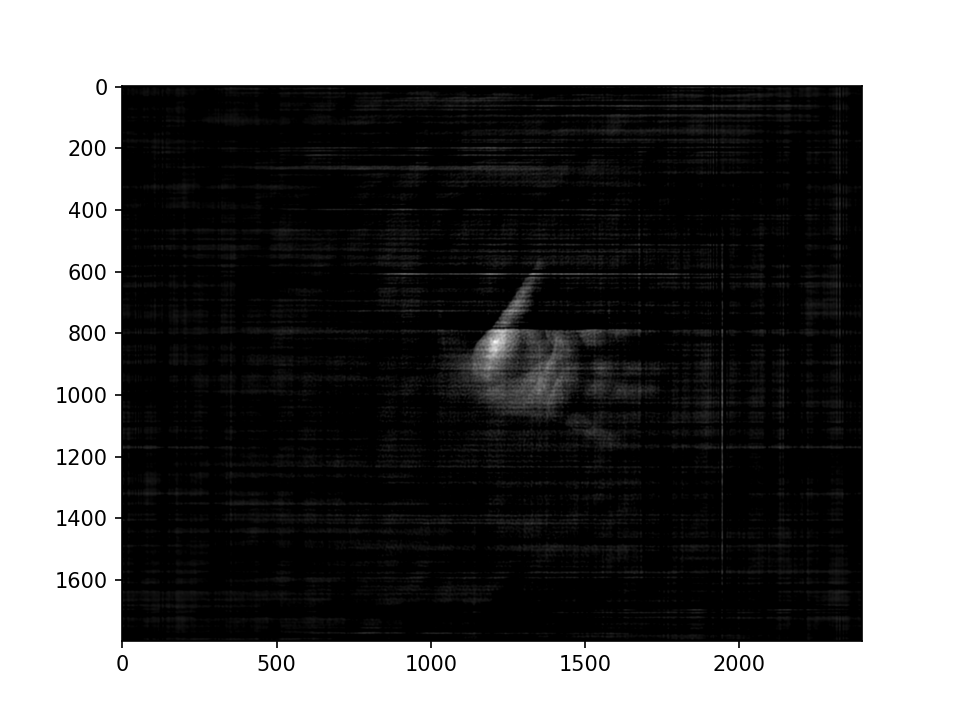

In [22]:
imshow(np.maximum(0,v_admm), cmap='gray')